In [2]:
import csv

reviews = {}
with open('IMDB_reviews.tsv','r') as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')
    for row in tsvin:
        reviews[row[0]] = row[1:]

In [3]:
import nltk

print(reviews['785_9'][1])

Me being of Irish origins, loved this movie, Not only was the guy hot and funny he was also sincere and honest. I loved the girl who he fell in love with too, she was pretty. They were such a cute couple. The ending was so sad. Love this movie! Although it is a little dirty, it reminds of a British or Irish version of Prime. If you liked this movie you should watch prime. Same story line young guy falls for older women, older women falls for young guy to. A lot of paths cross, in the end, the best decision is made or task is completed. Don't have anything else to say, without ruining the whole movie, all though I thought the french guy was ugly, less appealing to me. Umm...if you like Irish movies, I would recommend \Circle of Friends\" ,that movie is so good. Quick quote, you might not get unless you watch it\" well, thats my dinner ruined.\" LOL"


In [4]:
for k in reviews.keys():
    reviews[k][1] = nltk.sent_tokenize(reviews[k][1])

In [5]:
print(reviews['785_9'][1])

['Me being of Irish origins, loved this movie, Not only was the guy hot and funny he was also sincere and honest.', 'I loved the girl who he fell in love with too, she was pretty.', 'They were such a cute couple.', 'The ending was so sad.', 'Love this movie!', 'Although it is a little dirty, it reminds of a British or Irish version of Prime.', 'If you liked this movie you should watch prime.', 'Same story line young guy falls for older women, older women falls for young guy to.', 'A lot of paths cross, in the end, the best decision is made or task is completed.', "Don't have anything else to say, without ruining the whole movie, all though I thought the french guy was ugly, less appealing to me.", 'Umm...if you like Irish movies, I would recommend \\Circle of Friends\\" ,that movie is so good.', 'Quick quote, you might not get unless you watch it\\" well, thats my dinner ruined.\\" LOL"']


In [6]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [7]:
from nltk.stem.porter import PorterStemmer


stemmer = PorterStemmer()

def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    sw = set(stopwords.words('english'))
    return [stemmer.stem(w) for w in tokens if not w in sw]

for k in reviews.keys():
    w = []
    for sentence in reviews[k][1]:
        w.append(preprocess(sentence))
    reviews[k][1] = w

In [8]:
print(reviews['785_9'][1])

[['irish', 'origin', 'love', 'movi', 'guy', 'hot', 'funni', 'also', 'sincer', 'honest'], ['love', 'girl', 'fell', 'love', 'pretti'], ['cute', 'coupl'], ['end', 'sad'], ['love', 'movi'], ['although', 'littl', 'dirti', 'remind', 'british', 'irish', 'version', 'prime'], ['like', 'movi', 'watch', 'prime'], ['stori', 'line', 'young', 'guy', 'fall', 'older', 'women', 'older', 'women', 'fall', 'young', 'guy'], ['lot', 'path', 'cross', 'end', 'best', 'decis', 'made', 'task', 'complet'], ['anyth', 'els', 'say', 'without', 'ruin', 'whole', 'movi', 'though', 'thought', 'french', 'guy', 'ugli', 'less', 'appeal'], ['umm', 'like', 'irish', 'movi', 'would', 'recommend', 'circl', 'friend', 'movi', 'good'], ['quick', 'quot', 'might', 'get', 'unless', 'watch', 'well', 'that', 'dinner', 'ruin', 'lol']]


In [9]:
from scipy import sparse
from collections import defaultdict
import math


def construct_PPMI_matrix(sents, l=2, r=2):
    w_freq = defaultdict(int)
    c_freq = defaultdict(int)
    f_freq = defaultdict(int)
    combs = defaultdict(set)
    for sent in sents:
        s = sent # s = sent.split()
        n = len(s)
        for i in range(n):
            w = (s[i], )
            cl = tuple(s[max(i - l, 0): i])
            cr = tuple(s[i + 1: min(n, i + 1 + r)])
            
            w_freq[w] += 1
            c_freq[cl + cr] += 1
            f_freq[cl + w + cr] += 1
            combs[w].add((cl, cr))
    w_map = {w: i for i, w in enumerate(w_freq)}
    c_map = {c: i for i, c in enumerate(c_freq)}
    V = len(w_map)

    S = sparse.lil_matrix((len(w_freq), len(c_freq)))
    for w in combs:
        for (cl, cr) in combs[w]:
            S[w_map[w], c_map[cl + cr]] = \
                math.log(f_freq[cl + w + cr] * V /
                         (w_freq[w] * c_freq[cl + cr]))
    
    return S, w_map, w_freq

In [10]:
sents = []
for k in reviews.keys():
    for sentence in reviews[k][1]:
        sents.append(sentence)

print(sents[0])

['wil', 'bizarr', 'adapt', 'borg', 'short', 'stori', 'typic', 'cox']


In [11]:
S, w_map, w_freq = construct_PPMI_matrix(sents)

In [12]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=2)
reprs = svd.fit_transform(S)

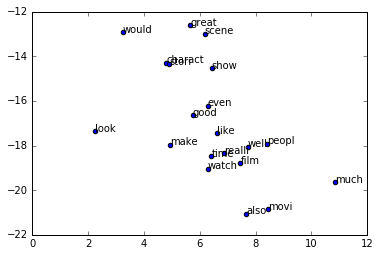

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt


freq_list = []
for x in w_freq:
    if len(x[0]) >= 4:
        freq_list.append((x, w_freq[x]))
    
freq_list.sort(key=lambda x: -x[1])

x = []
y = []
w = []
for i in range(20):
    wp = freq_list[i][0]
    c = reprs[w_map[wp]]
    w.append(wp[0])
    x.append(c[0])
    y.append(c[1])


fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(w):
    ax.annotate(txt, (x[i],y[i]))

In [14]:
import gensim

In [15]:
model = gensim.models.Word2Vec(sents)

In [16]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=0)

X = []
for i in range(20):
    wp = freq_list[i][0]
    X.append(model[wp[0]])

In [17]:
C = tsne.fit_transform(X)

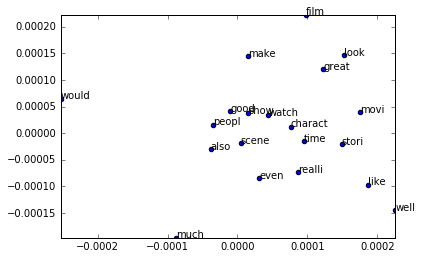

In [18]:
x = []
y = []
w = []

xmin = 1e9
xmax = -1e9
ymin = 1e9
ymax = -1e9

for i in range(20):
    wp = freq_list[i][0]
    w.append(wp[0])
    x.append(C[i][0])
    y.append(C[i][1])
    xmin = min(xmin, C[i][0])
    xmax = max(xmax, C[i][0])
    ymin = min(ymin, C[i][1])
    ymax = max(ymax, C[i][1])

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])


for i, txt in enumerate(w):
    ax.annotate(txt, (x[i],y[i]))

In [19]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

X = []
y = []

reviews.pop('id', None)

for k in reviews.keys():
    y.append(int(reviews[k][0]))
    X.append(k)

X = np.array(X)
y = np.array(y)
    
X_train = None
X_test = None
y_train = None
y_test = None
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [42]:
def prop(X):
    pos_cnt, neg_cnt = 0, 0

    for k in X:
        m = int(reviews[k][0])
        if m == 0:
            neg_cnt += 1
        else:
            pos_cnt += 1

    return pos_cnt / neg_cnt

print(prop(X), prop(X_train), prop(X_test))

1.0 1.0 1.0


In [20]:
def pos_neg_freq(reviews):
    neg_freq = {}
    pos_freq = {}

    for i in range(len(X_train)):
        k = X_train[i]
        if y_train[i] == 1:
            for s in reviews[k][1]:
                for w in s:
                    b = pos_freq.get(w, 0)
                    pos_freq[w] = b + 1
        else:
            for s in reviews[k][1]:
                for w in s:
                    b = neg_freq.get(w, 0)
                    neg_freq[w] = b + 1
    return pos_freq, neg_freq

pos_freq, neg_freq = pos_neg_freq(reviews)

In [21]:
print(pos_freq.get('bad',0), neg_freq.get('bad', 0))

1732 6650


In [44]:
def evaluate(reviews, pos_freq, neg_freq):
    err = 0

    for i in range(len(X_test)):
        k = X_test[i]
        pos = 0
        neg = 0
        for s in reviews[k][1]:
            for w in s:
                if pos_freq.get(w,0) >= neg_freq.get(w, 0):
                    pos += 1
                else:
                    neg += 1
        ans = 0
        if pos >= neg:
            ans = 1
        if ans != y_test[i]:
            err += 1

    return (len(X_test) - err) / len(X_test)

print(evaluate(reviews, pos_freq, neg_freq))

0.7948


In [23]:
from collections import defaultdict
import itertools
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from nltk.metrics.scores import precision, recall


def evaluate_classifier(features_extractor, train, test):
    """
         features_extractor - function for extraction features from review. 
         train, test - samples
    """
    train_feats = [(features_extractor(review), sent) for review, sent in train]
    test_feats = [(features_extractor(review), sent) for review, sent in test]
 
    classifier = NaiveBayesClassifier.train(train_feats)
    refsets = defaultdict(set)
    testsets = defaultdict(set)
 
    for i, (feats, label) in enumerate(test_feats):
            refsets[label].add(i)
            observed = classifier.classify(feats)
            testsets[observed].add(i)
 
    print('accuracy:', nltk.classify.util.accuracy(classifier, test_feats))
    print('pos precision:', precision(refsets[1], testsets[1]))
    print('pos recall:', recall(refsets[1], testsets[1]))
    print('neg precision:', precision(refsets[0], testsets[0]))
    print('neg recall:', recall(refsets[0], testsets[0]))
    classifier.show_most_informative_features()

In [24]:
def prep(X, y):
    X_new = []
    for i in range(len(X)):
        k = X[i]
        words = []
        for s in reviews[k][1]:
            for w in s:
                words.append(w)
        X_new.append((words, y[i]))
    
    return X_new    

In [25]:
train = prep(X_train, y_train)
test = prep(X_test, y_test)

In [26]:
def word_feats(words):
    return dict([(word, True) for word in words])

evaluate_classifier(word_feats, train, test)

accuracy: 0.8592
pos precision: 0.8277372262773722
pos recall: 0.9072
neg precision: 0.8973451327433628
neg recall: 0.8112
Most Informative Features
                    boll = True                0 : 1      =     33.0 : 1.0
                     uwe = True                0 : 1      =     32.3 : 1.0
                     edi = True                1 : 0      =     25.0 : 1.0
                   dreck = True                0 : 1      =     20.7 : 1.0
                intermin = True                0 : 1      =     19.7 : 1.0
                 harriet = True                1 : 0      =     19.7 : 1.0
                   capot = True                1 : 0      =     19.0 : 1.0
                   wayan = True                0 : 1      =     19.0 : 1.0
                    ajay = True                0 : 1      =     18.3 : 1.0
                  flimsi = True                0 : 1      =     18.2 : 1.0


In [27]:
from nltk.collocations import BigramCollocationFinder


def freq_scorer(n_ii, n_ix_xi_tuple, n_xx):
    return n_ii / n_xx

def bigram_word_feats(words, score_fn=freq_scorer, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])
 
evaluate_classifier(bigram_word_feats, train, test)

accuracy: 0.886
pos precision: 0.8731631863882444
pos recall: 0.9032
neg precision: 0.899751449875725
neg recall: 0.8688
Most Informative Features
       ('worst', 'film') = True                0 : 1      =     95.4 : 1.0
        ('hour', 'life') = True                0 : 1      =     48.3 : 1.0
         ('br', 'worst') = True                0 : 1      =     48.3 : 1.0
       ('total', 'wast') = True                0 : 1      =     47.7 : 1.0
          ('movi', 'aw') = True                0 : 1      =     39.7 : 1.0
       ('even', 'worth') = True                0 : 1      =     39.0 : 1.0
            ('aw', 'br') = True                0 : 1      =     38.3 : 1.0
         ('skip', 'one') = True                0 : 1      =     37.0 : 1.0
       ('worst', 'movi') = True                0 : 1      =     34.8 : 1.0
        ('piec', 'crap') = True                0 : 1      =     34.4 : 1.0


In [28]:
def chi_square_scorer(n_ii, n_ix_xi_tuple, n_xx):
    (n_ix, n_xi) = n_ix_xi_tuple
    n_oi = n_xi - n_ii
    n_io = n_ix - n_ii
    n_oo = n_xx - n_ii - n_oi - n_io
    chi_sq = n_xx * ((n_ii*n_oo - n_io*n_oi)**2 / 
                    ((n_ii + n_io) * (n_ii + n_oi) * (n_io + n_oo) * (n_oi + n_oo)))
    return chi_sq

def bigram_word_feats(words, score_fn=chi_square_scorer, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])
 
evaluate_classifier(bigram_word_feats, train, test)

accuracy: 0.8848
pos precision: 0.8722910216718266
pos recall: 0.9016
neg precision: 0.8981788079470199
neg recall: 0.868
Most Informative Features
       ('worst', 'film') = True                0 : 1      =     95.0 : 1.0
             ('2', '10') = True                0 : 1      =     51.6 : 1.0
        ('hour', 'life') = True                0 : 1      =     47.7 : 1.0
             ('3', '10') = True                0 : 1      =     47.2 : 1.0
             ('0', '10') = True                0 : 1      =     38.3 : 1.0
         ('skip', 'one') = True                0 : 1      =     37.7 : 1.0
       ('even', 'worth') = True                0 : 1      =     37.0 : 1.0
        ('piec', 'crap') = True                0 : 1      =     36.4 : 1.0
          ('movi', 'aw') = True                0 : 1      =     36.3 : 1.0
      ('read', 'script') = True                0 : 1      =     36.3 : 1.0


In [29]:
def prep(X):
    X_new = []
    for i in range(len(X)):
        s = []
        for j in range(100):
            s.append(0)
        
        c = 0
        for w in X[i][0]:
            if w in model:
                c += 1
                for j in range(100):
                    s[j] += model[w][j]
        
        for j in range(100):
            s[j] /= c
        X_new.append(s)
    return X_new

train_dataset = prep(train)
test_dataset = prep(test)

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten, Reshape
from keras.optimizers import SGD


def compile_model(model, learning_rate=0.1, d=1e-6):
    sgd = SGD(lr=learning_rate, decay=d) 
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['categorical_accuracy'])
    
    return model

def model1():
    model = Sequential()
    model.add(Dense(2, input_dim=100))
    model.add(Activation('softmax'))

    return model

def train_and_test_model(model, train_dataset, train_labels, test_dataset, test_labels, bs=256, epoch=20):
    model.fit(train_dataset, train_labels, batch_size=bs, nb_epoch=epoch)
    score = model.evaluate(test_dataset, test_labels)
    print(score)

ImportError: No module named 'keras'

In [31]:
def labels_one_hot_encoding(labels):
    l = len(labels)
    tl = np.zeros((l, 2))
    tl[np.arange(l), labels] = 1
    return tl

train_labels = labels_one_hot_encoding(y_train)
test_labels = labels_one_hot_encoding(y_test)

In [32]:
print(train_and_test_model(compile_model(model1()), train_dataset, train_labels, test_dataset, test_labels, bs=50, epoch=20))

Epoch 1/20
22500/22500 [==============================] - 0s - loss: 0.5083 - categorical_accuracy: 0.7692     
Epoch 2/20
22500/22500 [==============================] - 0s - loss: 0.4270 - categorical_accuracy: 0.8148     
Epoch 3/20
22500/22500 [==============================] - 0s - loss: 0.4074 - categorical_accuracy: 0.8244     
Epoch 4/20
22500/22500 [==============================] - 0s - loss: 0.3971 - categorical_accuracy: 0.8286     
Epoch 5/20
22500/22500 [==============================] - 0s - loss: 0.3910 - categorical_accuracy: 0.8317     
Epoch 6/20
22500/22500 [==============================] - 0s - loss: 0.3869 - categorical_accuracy: 0.8347     
Epoch 7/20
22500/22500 [==============================] - 0s - loss: 0.3838 - categorical_accuracy: 0.8354     
Epoch 8/20
22500/22500 [==============================] - 0s - loss: 0.3818 - categorical_accuracy: 0.8360     
Epoch 9/20
22500/22500 [==============================] - 0s - loss: 0.3797 - categorical_accuracy: 0.83

In [33]:
rev_len = 100

def prep3(X, model):
    X_new = []
    for i in range(len(X)):
        k = X[i]
        words = []
        j = 0
        for s in reviews[k][1]:
            for w in s:
                if w in model:
                    if j < rev_len:
                        words.append(np.array(model[w]))
                        j += 1
                
        
        while j < rev_len:
            a = np.empty(100)
            a.fill(0)
            words.append(a)
            j += 1
        
        X_new.append(np.array(words))
    return np.array(X_new)

In [34]:
X_train2 = prep3(X_train, model)
X_test2 = prep3(X_test, model)

print(X_train2.shape)

(22500, 100, 100)


In [35]:
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, SimpleRNN, GRU


def model2(seq_len):
    model = Sequential()
    model.add(LSTM(seq_len, input_shape=(seq_len, 100), dropout_W=0.2, dropout_U=0.2)) 
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model2 = model2(rev_len)

In [36]:
print(X_train2.shape)

model2.fit(X_train2, y_train, batch_size=50, nb_epoch=15)
score, acc = model2.evaluate(X_test2, y_test, batch_size=50)
print('Test score:', score)
print('Test accuracy:', acc)

(22500, 100, 100)
Epoch 1/15
22500/22500 [==============================] - 110s - loss: 0.6284 - acc: 0.6562   
Epoch 2/15
22500/22500 [==============================] - 107s - loss: 0.5669 - acc: 0.7260   
Epoch 3/15
22500/22500 [==============================] - 122s - loss: 0.5367 - acc: 0.7334   
Epoch 4/15
22500/22500 [==============================] - 125s - loss: 0.5070 - acc: 0.7598   
Epoch 5/15
22500/22500 [==============================] - 108s - loss: 0.5107 - acc: 0.7639   
Epoch 6/15
22500/22500 [==============================] - 108s - loss: 0.4624 - acc: 0.7895   
Epoch 7/15
22500/22500 [==============================] - 108s - loss: 0.4334 - acc: 0.8031   
Epoch 8/15
22500/22500 [==============================] - 108s - loss: 0.4115 - acc: 0.8180   
Epoch 9/15
22500/22500 [==============================] - 109s - loss: 0.3969 - acc: 0.8224   
Epoch 10/15
22500/22500 [==============================] - 108s - loss: 0.3871 - acc: 0.8294   
Epoch 11/15
22500/22500 [======